# Installation

In [71]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
%pip install -e ..

Obtaining file:///Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=9609 sha256=40ef13842cdea3e9c95629eec0d7b99bbf078208e412c751cadb9fdc65f1369e
  Stored in directory: /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-ephem-wheel-cache-k4c0ki85/wheels/9d/dd/1c/d0e8ab6bde11a84556c00bd645333aaad0b90e2c38e11b0ed1
Successfully built tempo_embeddings
  Attempting uninstall: tempo_embeddings
    Found existing installation: tempo_embeddings 0.0.1
    Uninstalling tempo_embeddings-0.0.1:
      Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the ke

In [73]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# Initialize Database

In [2]:
from ipywidgets import widgets

host_selector = widgets.Dropdown(
    options=[("local", "localhost"), ("Research Cloud", "145.38.192.173")],
    value="145.38.192.173",
    description="DB Server:",
)
host_selector

Dropdown(description='DB Server:', index=1, options=(('local', 'localhost'), ('Research Cloud', '145.38.192.17…

In [75]:
%autoreload now

In [3]:
import weaviate
from tempo_embeddings.embeddings.model import SentenceTransformerModelWrapper
from tempo_embeddings.embeddings.weaviate_database import WeaviateDatabaseManager
from tempo_embeddings.settings import DEFAULT_LANGUAGE_MODEL

db = WeaviateDatabaseManager(
    client=weaviate.connect_to_local(host=host_selector.value, port=8087),
    model=SentenceTransformerModelWrapper.from_pretrained(DEFAULT_LANGUAGE_MODEL),
)

ERROR:root:No corpus directory found in [PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris'), PosixPath('/Users/carstenschnober/SEED_DATA/SemanticsSustainability'), PosixPath('/data/datasets/research-semantics-of-sustainability/semantics-of-sustainability/data'), PosixPath('/home/cschnober/data'), PosixPath('/Volumes/i-lab.data.uu.nl/research-semantics-of-sustainability/semantics-of-sustainability/data')]
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/Cython/Distutils/old_build_ext.py:15: DeprecationWarning: dep_util is Deprecated. Use functions from setuptools instead.
  from distutils.dep_util import newer, newer_group


# Search

In [4]:
from ipywidgets import widgets

collection_selector = widgets.SelectMultiple(
    options=list(db.get_available_collections()),
    value=["ANP", "StatenGeneraal"],
    description="Choose a Collection:",
    disabled=False,
    style={"description_width": "initial"},
)
collection_selector

SelectMultiple(description='Choose a Collection:', index=(3, 5), options=('NRC', 'Trouw', 'AlgemeenDagblad', '…

In [5]:
text_widget = widgets.Text(
    placeholder="Enter a term", description="Search Term:", disabled=False
)
text_widget

Text(value='', description='Search Term:', placeholder='Enter a term')

# Plot Frequencies

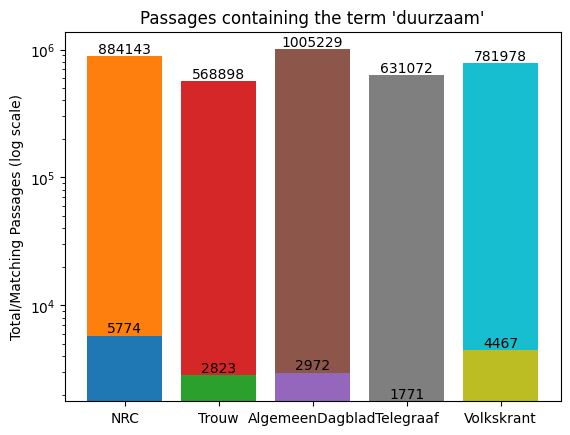

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_title(f"Passages containing the term '{text_widget.value}'")

ax.set_ylabel("Total/Matching Passages (log scale)")
ax.set_yscale("log")

for collection in collection_selector.value:
    doc_freq = db.doc_frequency(text_widget.value, collection)
    total_count = db.doc_frequency("", collection)

    bar_matches = ax.bar(collection, doc_freq, label=f"{collection} - Matches")
    ax.bar_label(bar_matches, fmt="%d", label_type="edge")

    bar_total = ax.bar(
        collection,
        total_count - doc_freq,
        bottom=doc_freq,
        label=f"{collection} - Total",
    )
    ax.bar_label(bar_total, fmt="%d", label_type="edge")

# Frequencies Per Year

In [12]:
start = 1850
end = 2024

year_range = widgets.SelectionRangeSlider(
    options=[str(i) for i in range(start, end)],
    index=(0, end - 1 - start),
    description="Years",
    disabled=False,
)
year_range

SelectionRangeSlider(description='Years', index=(0, 173), options=('1850', '1851', '1852', '1853', '1854', '18…

In [25]:
import pandas as pd
from tqdm import tqdm

normalize = False

df = pd.DataFrame(index=range(int(year_range.value[0]), int(year_range.value[1])))

for collection in tqdm(collection_selector.value, unit="collection"):
    df[collection] = [
        db.doc_frequency(text_widget.value, collection, {"year": str(year)})
        for year in df.index
    ]

    if normalize:
        total_counts = [db.doc_frequency("", collection) for year in df.index]
        df[collection] = df[collection] / total_counts

100%|██████████| 5/5 [00:05<00:00,  1.07s/collection]


<Axes: >

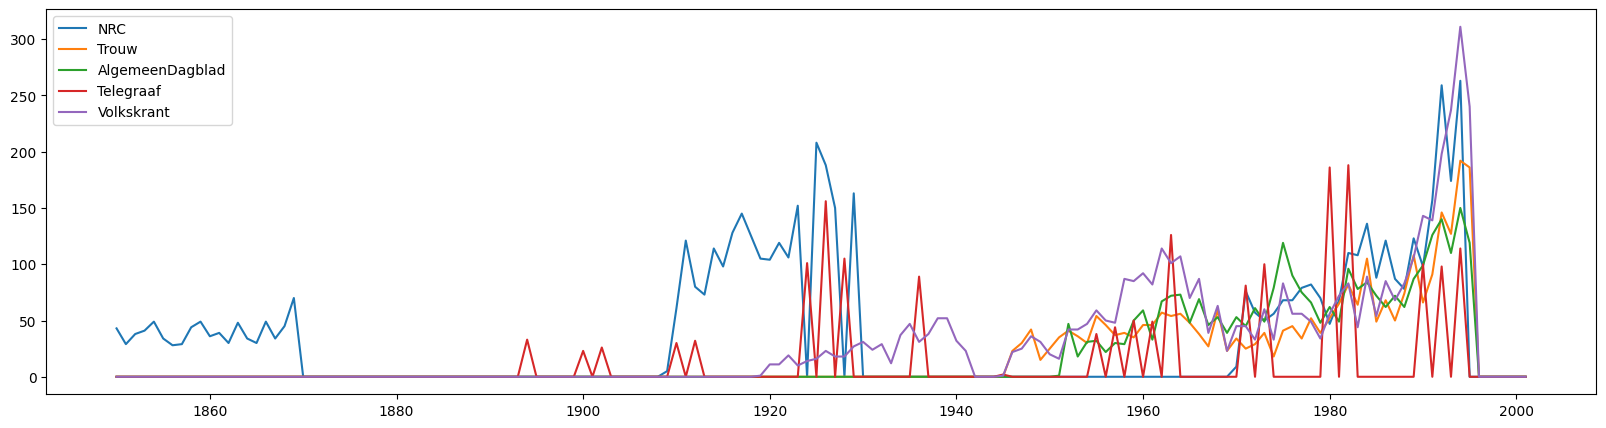

In [26]:
# TODO: interactive plot

df.plot(figsize=(20, 5))